# Custom implementation of Welch's method

Let's do the following: take the 20-seconds resting state EEG recording, split it up into 2-second segments that overlap by 50%, apply a hamming window to each one, and then take the DFT of each one. Square that DFT, and then take the average to arrive at a final PSD. This gives us the PSD of a single channel.

In [6]:
%matplotlib inline
import os
import glob
import seaborn
import numpy as np
import scipy as sp
import pandas as pd
import scipy.io
import scipy.signal
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import linregress
mpl.rcParams['figure.figsize'] = (16, 10)

In [20]:
data  = sp.io.loadmat('../data/examine-slope-fit/150hz-filt/120127130.mat')
srate = int(np.squeeze(data['srate']))
name  = str(np.squeeze(data['name']))
data  = np.squeeze(data['data'])
print('Subject:          ', name)
print('Sampling rate:    ', srate)
print('Number ch:        ', len(data))
print('Recording length: ', len(data[0]))
print('Record length, s: ', len(data[0])/512)

Subject:           120127130
Sampling rate:     512
Number ch:         58
Recording length:  10240
Record length, s:  20.0


In [83]:
def split_segs(x, nperseg=1024, noverlap=512):
    segs = []
    nsegs = (len(x)//noverlap) - 1
    for i in range(nsegs):
        segs.append(x[i*noverlap : i*noverlap + nperseg])
    return segs

In [99]:
segs = split_segs(data[0], nperseg=1024, noverlap=512)

In [114]:
hamming_segs = []
for s in segs:
    hamming_segs.append(sp.signal.hamming(len(s)) * s)

In [126]:
dft_segs = []
for s in hamming_segs:
    dft_segs.append( abs(np.fft.rfft(s)) ** 2 )

In [142]:
dft_segs = []
for s in segs:
    dft_segs.append( sp.signal.welch(s, fs=512, nperseg=1024, noverlap=0, window='hamming') )

In [172]:
final = np.mean([seg[1] for seg in dft_segs], axis=0)

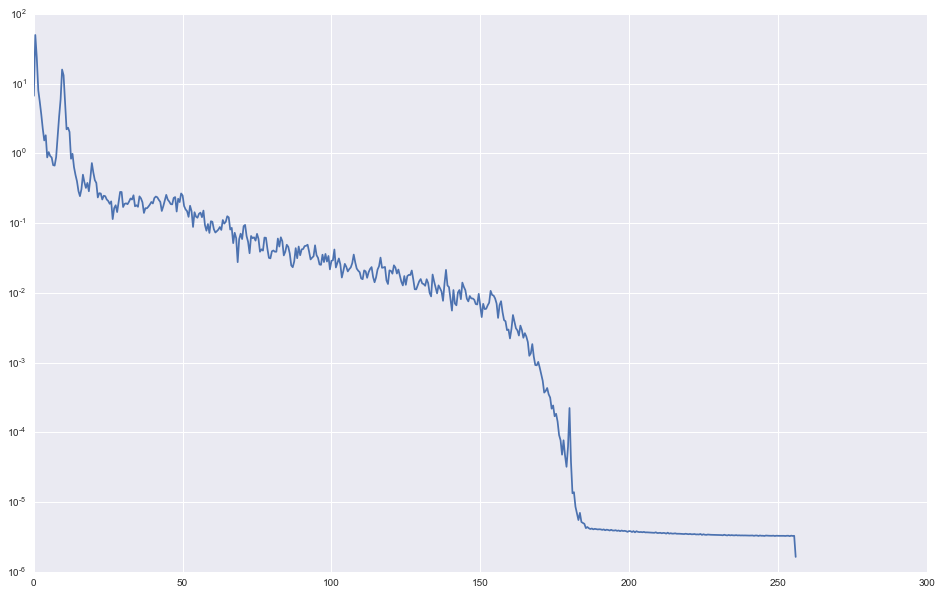

In [173]:
plt.semilogy(dft_segs[0][0], final)

In [174]:
f, psd = sp.signal.welch(data[0], srate, nperseg=srate*2, noverlap=srate, window='hamming')

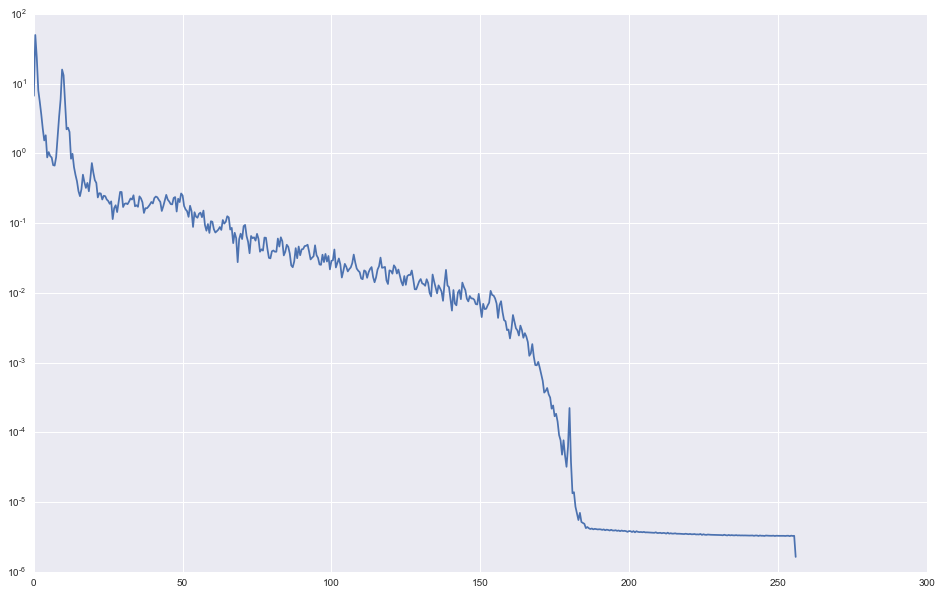

In [175]:
plt.semilogy(f, psd);

##### Let's compute the slope of every channel and look at what all of them together look like

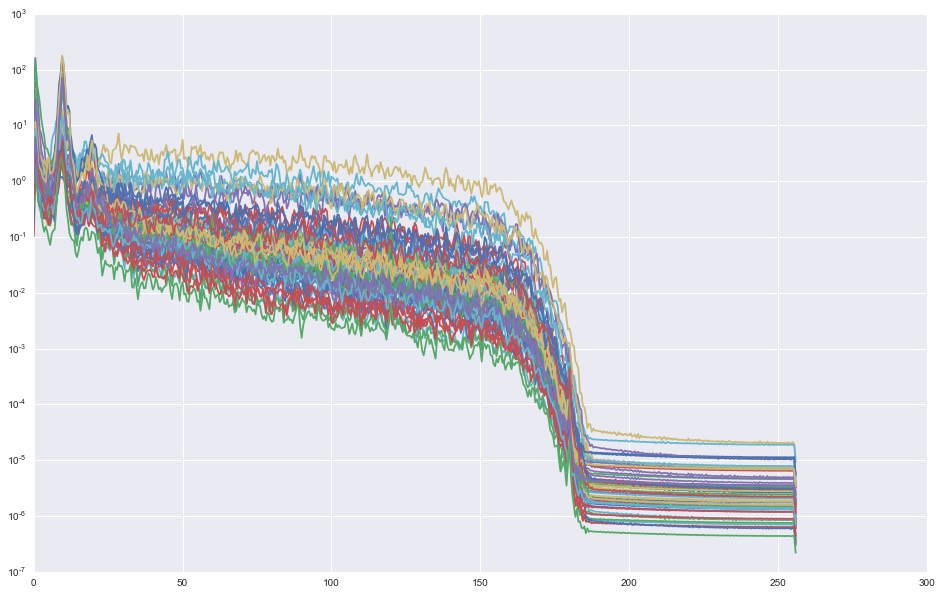

In [163]:
for i in range(len(data)):
    f, psd = sp.signal.welch(data[i], srate, nperseg=srate*2, noverlap=srate, window='hamming')
    plt.semilogy(f, psd)